In [1]:
"""
source this is build upon:

https://stackoverflow.com/questions/41947039/keras-rnn-with-lstm-cells-for-predicting-multiple-output-time-series-based-on-mu
"""

'\nsource this is build upon:\n\nhttps://stackoverflow.com/questions/41947039/keras-rnn-with-lstm-cells-for-predicting-multiple-output-time-series-based-on-mu\n'

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from IPython.display import display

print(tf.__version__)


font = {'family' : 'DejaVu Sans', 'weight' : 'bold', 'size'   : 20}

matplotlib.rc('font', **font)

2.1.0


# Toy example for the general structure

In [11]:
"""
Create data sample
"""
base_series = np.array([1, 3, 4, 1, 3, 4, 1, 3, 4])

toy_data = np.array([
    base_series, 
    base_series ** 2,
    base_series * 3,
    np.exp(np.linspace(1, 3, num = len(base_series))),
    np.cos(base_series * np.pi),
    10 - base_series,
    np.array([0, 0, 5, 0, 5, 0, 0, 0, 0])
])


toy_validation = np.array([
    base_series, 
    base_series ** 2.2,
    base_series * 6,
    np.exp(np.linspace(1, 3.5, num = len(base_series))),
    np.sin(base_series * np.pi),
    15 - base_series,
    np.array([0, 0, 10, 0, 0, 10, 0, 0, 10])
])


dim = toy_data.shape

toy_train_x = toy_data[:, 0:-1]
toy_train_x = toy_train_x.reshape(dim[0], dim[1] - 1, 1)

toy_train_y = toy_data[:, -1]
toy_train_y = toy_train_y.reshape(dim[0], 1)

toy_valid_x = toy_validation[:, 0:-1]
toy_valid_x = toy_valid_x.reshape(dim[0], dim[1] - 1, 1)

toy_valid_y = toy_validation[:, -1]
toy_valid_y = toy_valid_y.reshape(dim[0], 1)

In [12]:
toy_train_x, toy_train_x.shape

(array([[[ 1.        ],
         [ 3.        ],
         [ 4.        ],
         [ 1.        ],
         [ 3.        ],
         [ 4.        ],
         [ 1.        ],
         [ 3.        ]],
 
        [[ 1.        ],
         [ 9.        ],
         [16.        ],
         [ 1.        ],
         [ 9.        ],
         [16.        ],
         [ 1.        ],
         [ 9.        ]],
 
        [[ 3.        ],
         [ 9.        ],
         [12.        ],
         [ 3.        ],
         [ 9.        ],
         [12.        ],
         [ 3.        ],
         [ 9.        ]],
 
        [[ 2.71828183],
         [ 3.49034296],
         [ 4.48168907],
         [ 5.75460268],
         [ 7.3890561 ],
         [ 9.48773584],
         [12.18249396],
         [15.64263188]],
 
        [[-1.        ],
         [-1.        ],
         [ 1.        ],
         [-1.        ],
         [-1.        ],
         [ 1.        ],
         [-1.        ],
         [-1.        ]],
 
        [[ 9.        ],
 

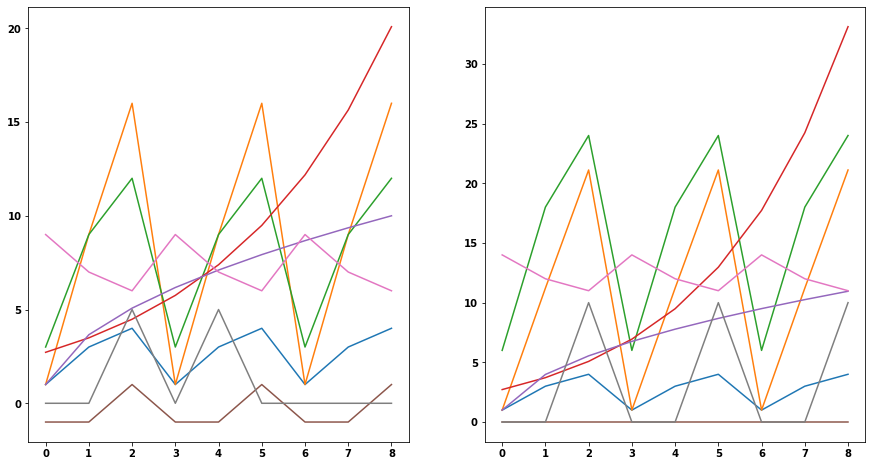

In [31]:
fig, ax = plt.subplots(1, 2, figsize = (15, 8))

for series in toy_data:
    ax[0].plot(
        series
    )

for series in toy_validation:
    ax[1].plot(
        series
    )
    
plt.show()

In [42]:
toy_model = tf.keras.Sequential()

toy_model.add( # first layer of the model
    tf.keras.layers.SimpleRNN(
        # The number of units is the number of neurons for the layer and every timestep
        units=256, 
        # return_sequences sets whether to output a sequence again, or just the last value of it
        return_sequences=True,  # we return a sequence since we'll have a 2nd rnn layer needing it
        # firt dimension of input_shape is length of the timeseries, setting it to None, we can feed timeseries of any length
        # second dimension is the dimension of the feature vector for a given point in time. So 1 for univariate, higher for multivariate timeseries
        input_shape=[None, 1]
        # batch_input_shape same as above, additionally first dimension is batch_size. Alternative for input_shape
        # batch_input_shape = [batchsize, None, 1]
    )
)  # Note: The output shape depends on input_shape and units!

toy_model.add(
    tf.keras.layers.SimpleRNN(
        units=256, 
        return_sequences=False,
        # input_shape=[None, 1]  # since it has a predecendent layer it figures the shape out by itself.
    )
)

toy_model.add(tf.keras.layers.Dense(1))

toy_model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9),
    metrics=["mae"]
)

toy_model.fit(
    x=toy_train_x, y=toy_train_y,
    validation_data=(toy_valid_x, toy_valid_y),
    epochs=600, verbose=0
)



In [63]:
test = np.array([0, 1, 2, 3, 4])

display(test[:-1], test[-1])

array([0, 1, 2, 3])

4

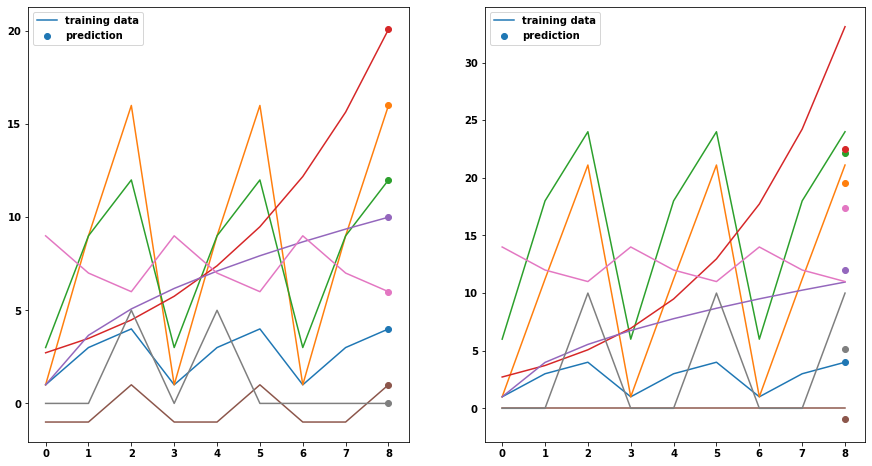

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

prediction = toy_model.predict(toy_valid_x)
for i, series in enumerate(toy_validation):
    ax[1].plot(
        series, label='training data'
    )
    ax[1].scatter(8, prediction[i], label='prediction')
    if i == 0:
        ax[1].legend()
    
prediction = toy_model.predict(toy_train_x)
for i, series in enumerate(toy_data):
    ax[0].plot(
        series, label='training data'
    )
    ax[0].scatter(8, prediction[i], label='prediction')
    if i == 0:
        ax[0].legend()

plt.show()

# Forecasting multiple timeseries / multivariate timeseries

In [44]:
"""
Create data sample
"""
base_series = np.array([1, 3, 4, 1, 3, 4, 1, 3, 4])


toy_data_multi = np.array([
    np.array([base_series, np.repeat(1, len(base_series))]).T,
    np.array([base_series * 2, np.repeat(2, len(base_series))]).T
])

dim = toy_data_multi.shape

print(
    toy_data_multi[:],
    toy_data_multi,
    sep="\n --- \n"
)

[[[1 1]
  [3 1]
  [4 1]
  [1 1]
  [3 1]
  [4 1]
  [1 1]
  [3 1]
  [4 1]]

 [[2 2]
  [6 2]
  [8 2]
  [2 2]
  [6 2]
  [8 2]
  [2 2]
  [6 2]
  [8 2]]]
 --- 
[[[1 1]
  [3 1]
  [4 1]
  [1 1]
  [3 1]
  [4 1]
  [1 1]
  [3 1]
  [4 1]]

 [[2 2]
  [6 2]
  [8 2]
  [2 2]
  [6 2]
  [8 2]
  [2 2]
  [6 2]
  [8 2]]]


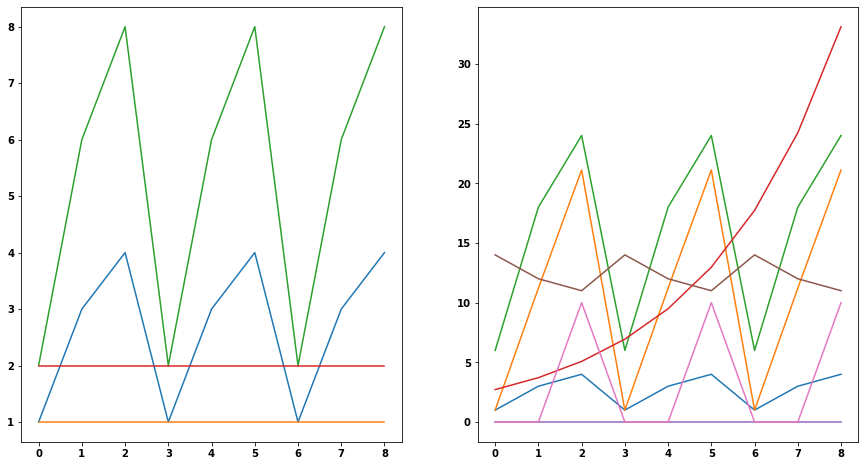

In [36]:
fig, ax = plt.subplots(1, 2, figsize = (15, 8))

for series in toy_data_multi:
    ax[0].plot(
        series
    )

for series in toy_validation:
    ax[1].plot(
        series
    )
    
plt.show()

In [49]:
toy_model_multi = tf.keras.Sequential()

toy_model_multi.add( # first layer of the model
    tf.keras.layers.SimpleRNN(
        # The number of units is the number of neurons for the layer and every timestep
        units=256, 
        # return_sequences sets whether to output a sequence again, or just the last value of it
        return_sequences=True,  # we return a sequence since we'll have a 2nd rnn layer needing it
        # firt dimension of input_shape is length of the timeseries, setting it to None, we can feed timeseries of any length
        # second dimension is the dimension of the feature vector for a given point in time. So 1 for univariate, higher for multivariate timeseries
        input_shape=[None, 2]
        # batch_input_shape same as above, additionally first dimension is batch_size. Alternative for input_shape
        # batch_input_shape = [batchsize, None, 1]
    )
)  # Note: The output shape depends on input_shape and units!

toy_model_multi.add(
    tf.keras.layers.SimpleRNN(
        units=256, 
        return_sequences=False,
        # input_shape=[None, 1]  # since it has a predecendent layer it figures the shape out by itself.
    )
)

toy_model_multi.add(tf.keras.layers.Dense(1))

toy_model_multi.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9),
    metrics=["mse"]
)

toy_model_multi.fit(
    x=toy_data_multi, y=np.array([1, 2]),
#    validation_data=(toy_valid_x, toy_valid_y),
    epochs=10, verbose=1
)

Train on 2 samples
Epoch 1/10
2/2 [==============================] - 1s 648ms/sample - loss: 0.9097 - mse: 2.1975
Epoch 2/10
2/2 [==============================] - 0s 9ms/sample - loss: 0.3533 - mse: 0.7208
Epoch 3/10
2/2 [==============================] - 0s 11ms/sample - loss: 0.1337 - mse: 0.2673
Epoch 4/10
2/2 [==============================] - 0s 12ms/sample - loss: 0.5361 - mse: 1.1363
Epoch 5/10
2/2 [==============================] - 0s 10ms/sample - loss: 0.5961 - mse: 1.2686
Epoch 6/10
2/2 [==============================] - 0s 14ms/sample - loss: 0.2349 - mse: 0.4698
Epoch 7/10
2/2 [==============================] - 0s 11ms/sample - loss: 0.0334 - mse: 0.0668
Epoch 8/10
2/2 [==============================] - 0s 11ms/sample - loss: 0.2640 - mse: 0.5280
Epoch 9/10
2/2 [==============================] - 0s 12ms/sample - loss: 0.3687 - mse: 0.7374
Epoch 10/10
2/2 [==============================] - 0s 12ms/sample - loss: 0.1585 - mse: 0.3169


In [51]:
toy_model_multi.predict(toy_data_multi)

array([[1.0168374],
       [1.9127213]], dtype=float32)

# Input timeseries output timeseries

In [7]:
################
# create synthetic dataset
################

def random_sample(len_timeseries=3000):
    Nchoice = 600
    x1 = np.cos(np.arange(0,len_timeseries)/float(1.0 + np.random.choice(Nchoice)))
    x2 = np.cos(np.arange(0,len_timeseries)/float(1.0 + np.random.choice(Nchoice)))
    x3 = np.sin(np.arange(0,len_timeseries)/float(1.0 + np.random.choice(Nchoice)))
    x4 = np.sin(np.arange(0,len_timeseries)/float(1.0 + np.random.choice(Nchoice)))
    y1 = np.random.random(len_timeseries)
    y2 = np.random.random(len_timeseries)
    y3 = np.random.random(len_timeseries)
    for t in range(3,len_timeseries):
        ## the output time series depend on input as follows: 
        y1[t] = x1[t-2] 
        y2[t] = x2[t-1]*x3[t-2]
        y3[t] = x4[t-3]
    y = np.array([y1,y2,y3]).T # .T is transpose
    X = np.array([x1,x2,x3,x4]).T
    return y, X

def generate_data(Nsequence = 1000):
    X_train = []
    y_train = []
    for isequence in range(Nsequence):
        y, X = random_sample()
        X_train.append(X)
        y_train.append(y)
    return np.array(X_train),np.array(y_train)

Nsequence = 100
prop = 0.5
Ntrain = int(Nsequence*prop)
X, y = generate_data(Nsequence)
X_train = X[:Ntrain,:,:]
X_test  = X[Ntrain:,:,:]
y_train = y[:Ntrain,:,:]
y_test  = y[Ntrain:,:,:] 

#X.shape = (N sequence, length of time series, N input features)
#y.shape = (N sequence, length of time series, N targets)
print(X.shape, y.shape)
# (100, 3000, 4) (100, 3000, 3)

(100, 3000, 4) (100, 3000, 3)


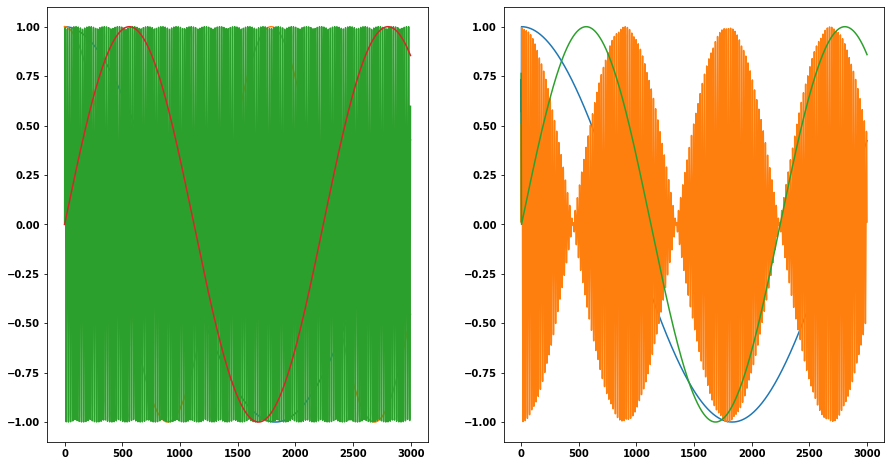

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

ax[0].plot(
    X[0]
)

ax[1].plot(
    y[0]
)

plt.show()

Train on 1500 samples, validate on 1500 samples
Epoch 1/25
1500/1500 [==============================] - 3s 2ms/sample - loss: 0.5830 - val_loss: 0.5389
Epoch 2/25
1500/1500 [==============================] - 1s 830us/sample - loss: 0.4936 - val_loss: 0.4568
Epoch 3/25
1500/1500 [==============================] - 1s 818us/sample - loss: 0.4149 - val_loss: 0.3826
Epoch 4/25
1500/1500 [==============================] - 1s 814us/sample - loss: 0.3448 - val_loss: 0.3171
Epoch 5/25
1500/1500 [==============================] - 1s 810us/sample - loss: 0.2841 - val_loss: 0.2625
Epoch 6/25
1500/1500 [==============================] - 1s 807us/sample - loss: 0.2370 - val_loss: 0.2223
Epoch 7/25
1500/1500 [==============================] - 1s 804us/sample - loss: 0.2033 - val_loss: 0.1940
Epoch 8/25
1500/1500 [==============================] - 1s 800us/sample - loss: 0.1793 - val_loss: 0.1746
Epoch 9/25
1500/1500 [==============================] - 1s 804us/sample - loss: 0.1609 - val_loss: 0.1584


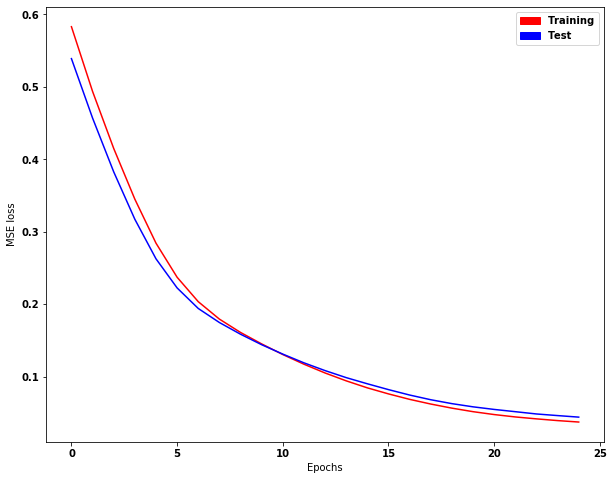

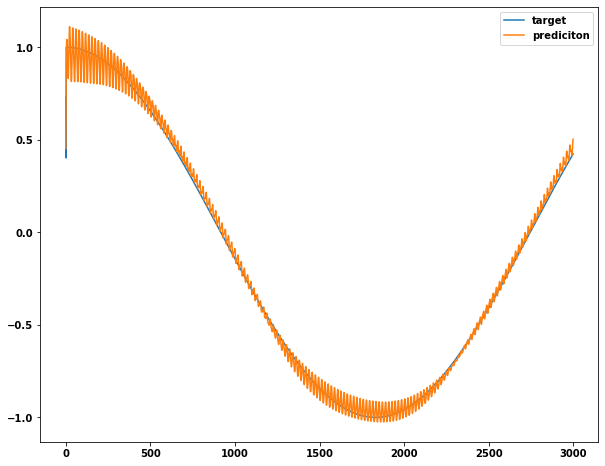

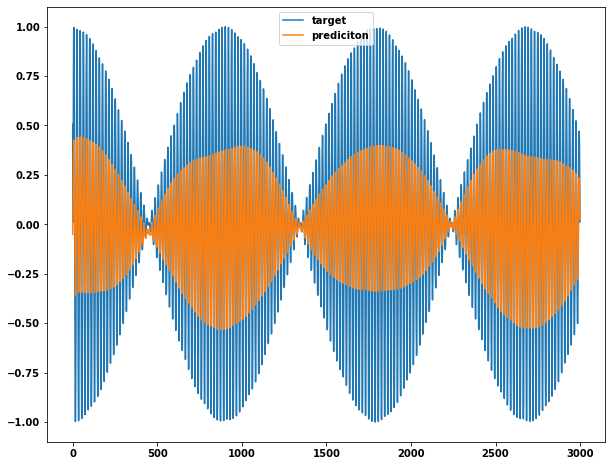

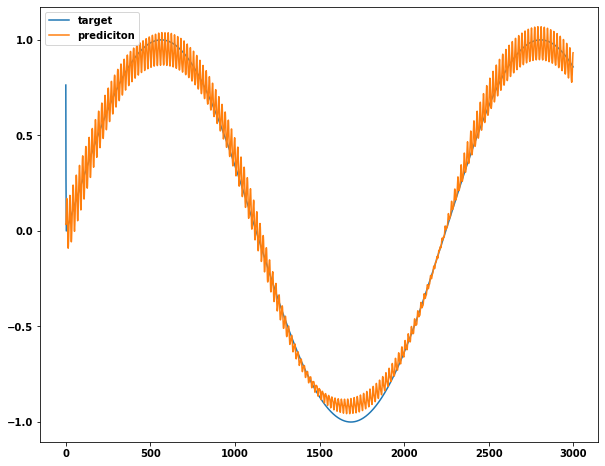

In [9]:
####################
# Cutting function #
####################
def stateful_cut(arr, batch_size, T_after_cut):
    if len(arr.shape) != 3:
        # N: Independent sample size,
        # T: Time length,
        # m: Dimension
        print("ERROR: please format arr as a (N, T, m) array.")

    N = arr.shape[0]
    T = arr.shape[1]

    # We need T_after_cut * nb_cuts = T
    nb_cuts = int(T / T_after_cut)
    if nb_cuts * T_after_cut != T:
        print("ERROR: T_after_cut must divide T")

    # We need batch_size * nb_reset = N
    # If nb_reset = 1, we only reset after the whole epoch, so no need to reset
    nb_reset = int(N / batch_size)
    if nb_reset * batch_size != N:
        print("ERROR: batch_size must divide N")

    # Cutting (technical)
    cut1 = np.split(arr, nb_reset, axis=0)
    cut2 = [np.split(x, nb_cuts, axis=1) for x in cut1]
    cut3 = [np.concatenate(x) for x in cut2]
    cut4 = np.concatenate(cut3)
    return(cut4)

#############
# Main code #
#############

##
# Data
##
N = X_train.shape[0] # size of samples
T = X_train.shape[1] # length of each time series
batch_size = N # number of time series considered together: batch_size | N
T_after_cut = 100 # length of each cut part of the time series: T_after_cut | T
dim_in = X_train.shape[2] # dimension of input time series
dim_out = y_train.shape[2] # dimension of output time series

inputs, outputs, inputs_test, outputs_test = \
  [stateful_cut(arr, batch_size, T_after_cut) for arr in \
  [X_train, y_train, X_test, y_test]]

##
# Model
##
nb_units = 10

model = Sequential()
model.add(LSTM(batch_input_shape=(batch_size, None, dim_in),
               return_sequences=True, units=nb_units, stateful=True))
model.add(TimeDistributed(Dense(activation='linear', units=dim_out)))
model.compile(loss = 'mae', optimizer = 'rmsprop')

##
# Training
##
epochs = 25

nb_reset = int(N / batch_size)
if nb_reset > 1:
    print("ERROR: We need to reset states when batch_size < N")

# When nb_reset = 1, we do not need to reinitialize states
history = model.fit(inputs, outputs, epochs = epochs, 
                    batch_size = batch_size, shuffle=False,
                    validation_data=(inputs_test, outputs_test))

def plotting(history):
    plt.plot(history.history['loss'], color = "red")
    plt.plot(history.history['val_loss'], color = "blue")
    red_patch = mpatches.Patch(color='red', label='Training')
    blue_patch = mpatches.Patch(color='blue', label='Test')
    plt.legend(handles=[red_patch, blue_patch])
    plt.xlabel('Epochs')
    plt.ylabel('MSE loss')
    plt.show()

plt.figure(figsize=(10,8))
plotting(history) # Evolution of training/test loss

##
# Visual checking for a time series
##
## Mime model which is stateless but containing stateful weights
model_stateless = Sequential()
model_stateless.add(LSTM(input_shape=(None, dim_in),
               return_sequences=True, units=nb_units))
model_stateless.add(TimeDistributed(Dense(activation='linear', units=dim_out)))
model_stateless.compile(loss = 'mse', optimizer = 'rmsprop')
model_stateless.set_weights(model.get_weights())

## Prediction of a new set
i = 0 # time series selected (between 0 and N-1)
x = X_train[i]
y = y_train[i]
y_hat = model_stateless.predict(np.array([x]))[0]

for dim in range(3): # dim = 0 for y1 ; dim = 1 for y2 ; dim = 2 for y3.
    plt.figure(figsize=(10,8))
    plt.plot(range(T), y[:,dim], label="target")
    plt.plot(range(T), y_hat[:,dim], label="prediciton")
    plt.legend()
    plt.show()

## Conclusion: works almost perfectly.